In [1]:
# Importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
from mlxtend.evaluate import bias_variance_decomp
from statsmodels.tsa.stattools import adfuller
from itertools import product
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining function for data download
def download_data(ticker: str, period: str) -> pd.DataFrame:
    df = yf.download(ticker, period=period, multi_level_index=False)
    df.reset_index(inplace=True)
    return df

In [3]:
def create_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    price = df['Close']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    indicators = pd.DataFrame(index=df.index)

    # Moving Averages
    indicators['sma_5'] = price.rolling(window=5).mean()
    indicators['sma_10'] = price.rolling(window=10).mean()
    indicators['ema_5'] = price.ewm(span=5).mean()
    indicators['ema_10'] = price.ewm(span=10).mean()

    # Momentum Indicators
    indicators['momentum_5'] = price - price.shift(5)
    indicators['momentum_10'] = price - price.shift(10)
    indicators['roc_5'] = price.pct_change(5)
    indicators['roc_10'] = price.pct_change(10)

    # Volatility
    indicators['std_5'] = price.rolling(window=5).std()
    indicators['std_10'] = price.rolling(window=10).std()

    # RSI
    delta = price.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_gain = up.rolling(window=14).mean()
    avg_loss = down.rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    indicators['rsi_14'] = 100 - (100 / (1 + rs))

    # VWAP
    typical_price = (high + low + close) / 3
    vwap = (typical_price * volume).cumsum() / volume.cumsum()
    indicators['vwap'] = vwap

    # OBV
    obv = [0]
    for i in range(1, len(close)):
        if close[i] > close[i - 1]:
            obv.append(obv[-1] + volume[i])
        elif close[i] < close[i - 1]:
            obv.append(obv[-1] - volume[i])
        else:
            obv.append(obv[-1])
    indicators['obv'] = obv

    # ADX
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    tr = pd.concat([
        high - low,
        abs(high - close.shift()),
        abs(low - close.shift())
    ], axis=1).max(axis=1)
    atr = tr.rolling(14).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/14).mean() / atr)
    minus_di = 100 * (-minus_dm.ewm(alpha=1/14).mean() / atr)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di + 1e-10)
    indicators['adx_14'] = dx.ewm(alpha=1/14).mean()

    # ATR
    indicators['atr_14'] = atr

    # Bollinger Bands
    sma20 = price.rolling(20).mean()
    std20 = price.rolling(20).std()
    indicators['bollinger_upper'] = sma20 + 2 * std20
    indicators['bollinger_lower'] = sma20 - 2 * std20

    # MACD
    ema12 = price.ewm(span=12).mean()
    ema26 = price.ewm(span=26).mean()
    indicators['macd'] = ema12 - ema26

    # CCI (Commodity Channel Index)
    tp = (high + low + close) / 3
    cci = (tp - tp.rolling(20).mean()) / (0.015 * tp.rolling(20).std())
    indicators['cci_20'] = cci

    # Williams %R
    highest_high = high.rolling(14).max()
    lowest_low = low.rolling(14).min()
    indicators['williams_r'] = -100 * (highest_high - close) / (highest_high - lowest_low + 1e-10)

    # Stochastic Oscillator (%K)
    low14 = low.rolling(14).min()
    high14 = high.rolling(14).max()
    indicators['stochastic_k'] = 100 * (close - low14) / (high14 - low14 + 1e-10)

    return indicators.dropna().reset_index(drop=True)

In [4]:
# Defining function for creating the target variable
def compute_target(df: pd.DataFrame) -> pd.Series:
    return df['Close'].pct_change(periods=5).shift(-5)

In [5]:
# Defining function for walk forward optimization with PCA and VIF for feature extraction
def walk_forward_with_pca_vif(data, model, window_size=250, step_size=1, n_components=4):
    predictions = []
    prediction_indices = []

    for i in range(window_size, len(data) - 5, step_size):
        train_data = data.iloc[i - window_size:i]
        test_row = data.iloc[i]

        X_raw = train_data.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target'], errors='ignore')
        y_train = train_data['Target']

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

        vif_data = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
        vif_scores = [variance_inflation_factor(vif_data.values, j) for j in range(vif_data.shape[1])]
        selected_pcs = vif_data.loc[:, np.array(vif_scores) < 3]

        test_raw = test_row.drop(labels=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target'], errors='ignore').values.reshape(1, -1)
        test_scaled = scaler.transform(test_raw)
        test_pca = pca.transform(test_scaled)
        test_vif_df = pd.DataFrame(test_pca, columns=[f'PC{i+1}' for i in range(n_components)])
        test_selected = test_vif_df.loc[:, np.array(vif_scores) < 3]

        model_clone = clone(model)
        model_clone.fit(selected_pcs, y_train)
        prediction = model_clone.predict(test_selected)[0]

        predictions.append(prediction)
        prediction_indices.append(i)

    pred_series = pd.Series(data=np.nan, index=data.index)
    pred_series.iloc[prediction_indices] = predictions
    return pred_series

In [6]:
# Trading strategy formulation and backtesting
def backtest_strategy(final_data, initial_capital=10000, capital_deployed=0.2):
    trade_log = []
    for i in range(len(final_data) - 5):
        prediction = final_data.iloc[i]['Predictions']
        if prediction == 0 or np.isnan(prediction):
            continue

        direction = 'Long' if prediction > 0 else 'Short'
        entry_price = final_data.iloc[i + 1]['Open']
        exit_price = final_data.iloc[i + 5]['Close']

        trade_return = (exit_price - entry_price) / entry_price if direction == 'Long' else (entry_price - exit_price) / entry_price
        capital_change = capital_deployed * trade_return

        trade_log.append({
            'Signal_Day': i,
            'Entry_Day': i + 1,
            'Exit_Day': i + 5,
            'Direction': direction,
            'Entry_Price': entry_price,
            'Exit_Price': exit_price,
            'Return': trade_return,
            'Capital_Change': capital_change
        })

    return pd.DataFrame(trade_log)

In [7]:
# Evaluating trading strategy performance
def sharpe_ratio(equity_curve, risk_free_rate):
    daily_returns = equity_curve.pct_change().dropna()
    excess_returns = daily_returns - (risk_free_rate / 252)
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    return drawdown.min(), drawdown

In [8]:
# Calling the above functions
ticker = input("Enter a valid yfinance API ticker: ")
period = input("Enter the number of years for downloading data (e.g., 1y, 2y, 5y, 10y): ")
data = download_data(ticker, period)
indicators = create_technical_indicators(data)

Enter a valid yfinance API ticker:  AAPL
Enter the number of years for downloading data (e.g., 1y, 2y, 5y, 10y):  10y


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [9]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sma_5            2496 non-null   float64
 1   sma_10           2496 non-null   float64
 2   ema_5            2496 non-null   float64
 3   ema_10           2496 non-null   float64
 4   momentum_5       2496 non-null   float64
 5   momentum_10      2496 non-null   float64
 6   roc_5            2496 non-null   float64
 7   roc_10           2496 non-null   float64
 8   std_5            2496 non-null   float64
 9   std_10           2496 non-null   float64
 10  rsi_14           2496 non-null   float64
 11  vwap             2496 non-null   float64
 12  obv              2496 non-null   int64  
 13  adx_14           2496 non-null   float64
 14  atr_14           2496 non-null   float64
 15  bollinger_upper  2496 non-null   float64
 16  bollinger_lower  2496 non-null   float64
 17  macd          

In [10]:
# Aligning the data
data = data.iloc[-len(indicators):].reset_index(drop=True)
data_merged = pd.concat([data, indicators], axis=1)
data_merged['Target'] = compute_target(data_merged)
data_merged.dropna(inplace=True)

In [11]:
# Defining (six) different regression models for predicting the target variable
def get_models():
    return {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'DecisionTree': DecisionTreeRegressor(),
        'Bagging': BaggingRegressor(n_estimators=100),
        'RandomForest': RandomForestRegressor(n_estimators=100),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100)
    }

In [12]:
# Bias-variance decomposition
def evaluate_bias_variance_all(models, X, y, test_size=0.2):
    split = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    results = {}
    for name, model in models.items():
        avg_loss, bias, var = bias_variance_decomp(
            model,
            X_train.values, y_train.values,
            X_test.values, y_test.values,
            loss='mse',
            num_rounds=100,
            random_seed=42
        )
        results[name] = {
            'Total Error': avg_loss,
            'Bias': bias,
            'Variance': var,
            'Irreducible Error': avg_loss - bias - var
        }
    return pd.DataFrame(results).T

In [13]:
# Preparing the data
X_bv = indicators.copy().iloc[:len(data_merged)]
y_bv = data_merged['Target'].iloc[:len(X_bv)]

# Getting the models and evaluating them
models = get_models()
bv_results = evaluate_bias_variance_all(models, X_bv, y_bv)

# Printing results
print("Bias-Variance Decomposition for All Models:")
print(bv_results)

Bias-Variance Decomposition for All Models:
                  Total Error      Bias  Variance  Irreducible Error
LinearRegression     0.001751  0.001684  0.000067      -2.303930e-19
Ridge                0.001739  0.001678  0.000062      -2.710505e-20
DecisionTree         0.003332  0.001851  0.001480       2.168404e-19
Bagging              0.001865  0.001735  0.000130      -5.421011e-20
RandomForest         0.001866  0.001737  0.000129      -1.084202e-19
GradientBoosting     0.002007  0.001756  0.000251      -2.710505e-19


In [14]:
# Checking the order of integration of the predictor variables
def find_integration_order(series):
   """Determine the order of integration (d) using Augmented Dickey-Fuller test"""
   d = 0  # Initialize differencing order
   while True:
       # Perform ADF test
       result = adfuller(series, autolag='AIC')
       # Check if p-value <= 5% (stationary)
       if result[1] <= 0.05:
           # Return current differencing order if stationary
           return d
       # Difference the series
       series = series.apply(np.log).diff().dropna()
       # Increment differencing order
       d += 1
       # Safety check to prevent over-differencing
       if d >= 2:
           return d

In [15]:
# Checking the required differencing for all predictor variables
integration_orders = {}
for col in indicators.columns:
  integration_orders[col] = find_integration_order(indicators[col])

# Creating a DataFrame with indicators.columns as index
integration_orders = pd.DataFrame.from_dict(integration_orders, orient='index', columns=['Integration Order'])
integration_orders.index.name = 'Indicator'

# Checking the dataframe
integration_orders["Integration Order"].value_counts()

Integration Order
0    12
1     9
Name: count, dtype: int64

In [16]:
# Stationarizing the predictor variables
differenced_indicators = indicators.copy()

for indicator in integration_orders.index:
    order = integration_orders.loc[indicator, 'Integration Order']
    if order > 0:
      differenced_indicators[indicator] = differenced_indicators[indicator].diff(order).dropna()
differenced_indicators = differenced_indicators.dropna()

In [17]:
# Verifying whether the differencing is performed as expected
integration_orders_2 = {}
for col in differenced_indicators.columns:
  integration_orders_2[col] = find_integration_order(differenced_indicators[col])

# Creating a DataFrame with differenced_indicators.columns as index
integration_orders_2 = pd.DataFrame.from_dict(integration_orders_2, orient='index', columns=['Integration Order'])
integration_orders_2.index.name = 'Indicator'

# Checking the dataframe
integration_orders_2["Integration Order"].value_counts()

Integration Order
0    21
Name: count, dtype: int64

In [18]:
# Aligning the data
data = data.iloc[-len(differenced_indicators):].reset_index(drop=True)
data_merged_differenced = pd.concat([data, differenced_indicators], axis=1)
data_merged_differenced['Target'] = compute_target(data_merged_differenced)
data_merged_differenced.dropna(inplace=True)

In [19]:
data_merged_differenced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2490 entries, 1 to 2490
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2490 non-null   datetime64[ns]
 1   Close            2490 non-null   float64       
 2   High             2490 non-null   float64       
 3   Low              2490 non-null   float64       
 4   Open             2490 non-null   float64       
 5   Volume           2490 non-null   float64       
 6   sma_5            2490 non-null   float64       
 7   sma_10           2490 non-null   float64       
 8   ema_5            2490 non-null   float64       
 9   ema_10           2490 non-null   float64       
 10  momentum_5       2490 non-null   float64       
 11  momentum_10      2490 non-null   float64       
 12  roc_5            2490 non-null   float64       
 13  roc_10           2490 non-null   float64       
 14  std_5            2490 non-null   float64     

In [20]:
# Preparing the data
X_bv_differenced = differenced_indicators.copy().iloc[:len(data_merged_differenced)]
y_bv_differenced = data_merged_differenced['Target'].iloc[:len(X_bv)]

# Getting the models and evaluating them
models = get_models()
bv_results_differenced = evaluate_bias_variance_all(models, X_bv_differenced, y_bv_differenced)

# Printing results
print("Bias-Variance Decomposition for All Models with Stationarized Predictors:")
print(bv_results_differenced)

Bias-Variance Decomposition for All Models with Stationarized Predictors:
                  Total Error      Bias  Variance  Irreducible Error
LinearRegression     0.001693  0.001632  0.000061      -3.117081e-19
Ridge                0.001687  0.001630  0.000057      -1.219727e-19
DecisionTree         0.004017  0.001996  0.002021      -4.336809e-19
Bagging              0.001991  0.001858  0.000134      -1.897354e-19
RandomForest         0.002002  0.001866  0.000136       3.252607e-19
GradientBoosting     0.001955  0.001787  0.000168       5.149960e-19


### **Backtesting and Strategy Evaluation on Non-Stationarized Predictors**

In [21]:
# Running walk-forward prediction
model = GradientBoostingRegressor(n_estimators=100)
pred_series = walk_forward_with_pca_vif(data_merged, model)
data_merged['Predictions'] = pred_series
data_merged.dropna(subset=['Predictions'], inplace=True)

In [22]:
# Creating final dataset
final_data = data_merged[['Open', 'Close', 'Target', 'Predictions']].copy()

# Running backtest
trades_df = backtest_strategy(final_data)

In [23]:
# Converting relevant columns to two and four decimal places respectively
cols_to_round_to_two = ['Entry_Price', 'Exit_Price']
trades_df[cols_to_round_to_two] = trades_df[cols_to_round_to_two].round(2)
cols_to_round_to_four = ['Return', 'Capital_Change']
trades_df[cols_to_round_to_four] = trades_df[cols_to_round_to_four].round(4)

In [24]:
# Calculating equity
returns_series = pd.Series(0, index=final_data.index)
for _, row in trades_df.iterrows():
    returns_series.iloc[int(row['Exit_Day'])] += row['Capital_Change']
strategy_equity = 10000 * (1 + returns_series).cumprod()
buy_hold_equity = (final_data['Close'] / final_data['Open'].iloc[0]) * 10000

In [25]:
# Calculating trade metrics
rfr = float(input("Enter the risk-free rate (e.g., for 5.3%, enter only 5.3): "))
sharpe_strategy = sharpe_ratio(strategy_equity, rfr / 100)
sharpe_bh = sharpe_ratio(buy_hold_equity, rfr / 100)
mdd_strategy_val, mdd_strategy = max_drawdown(strategy_equity)
mdd_bh_val, mdd_bh = max_drawdown(buy_hold_equity)

Enter the risk-free rate (e.g., for 5.3%, enter only 5.3):  5.3


In [26]:
# Reindexing the dataframes to datetime index
date_index = pd.to_datetime(data_merged['Date'])

mdd_bh = pd.DataFrame(mdd_bh).set_index(date_index)
mdd_strategy = pd.DataFrame(mdd_strategy).set_index(date_index)
strategy_equity = pd.DataFrame(strategy_equity).set_index(date_index)
buy_hold_equity = pd.DataFrame(buy_hold_equity).set_index(date_index)

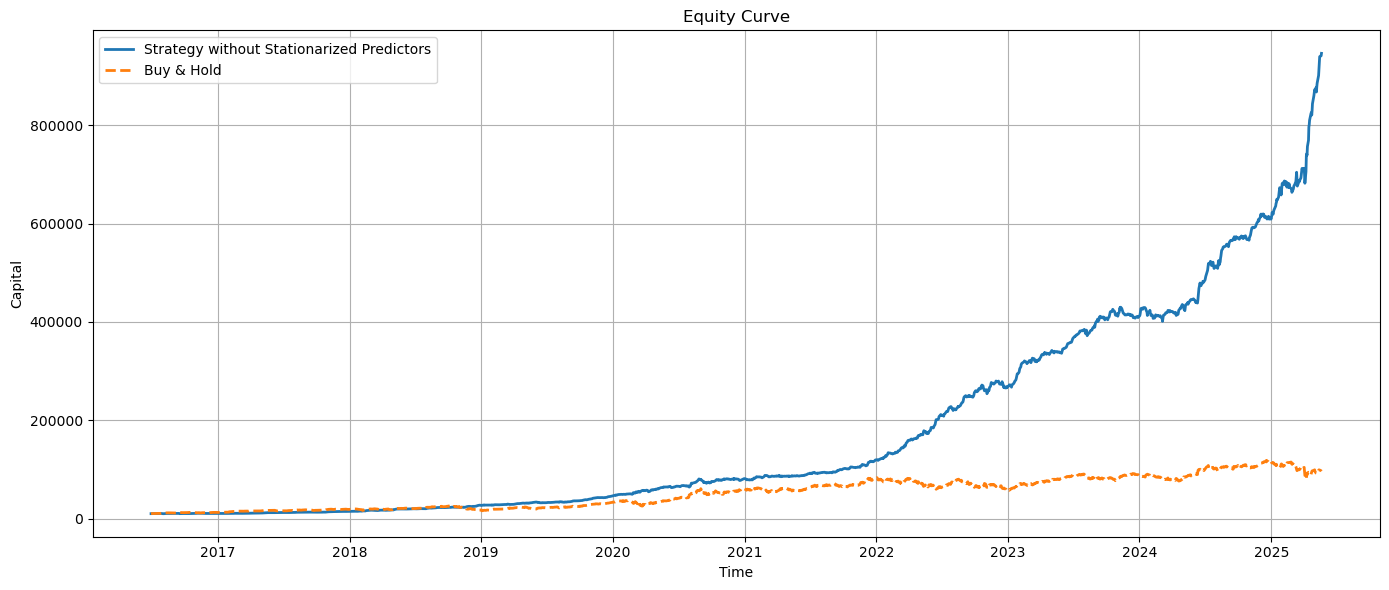

In [27]:
# Plotting equity
plt.figure(figsize=(14, 6))
plt.plot(strategy_equity, label='Strategy without Stationarized Predictors', linewidth=2)
plt.plot(buy_hold_equity, label='Buy & Hold', linestyle='--', linewidth=2)
plt.title('Equity Curve')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

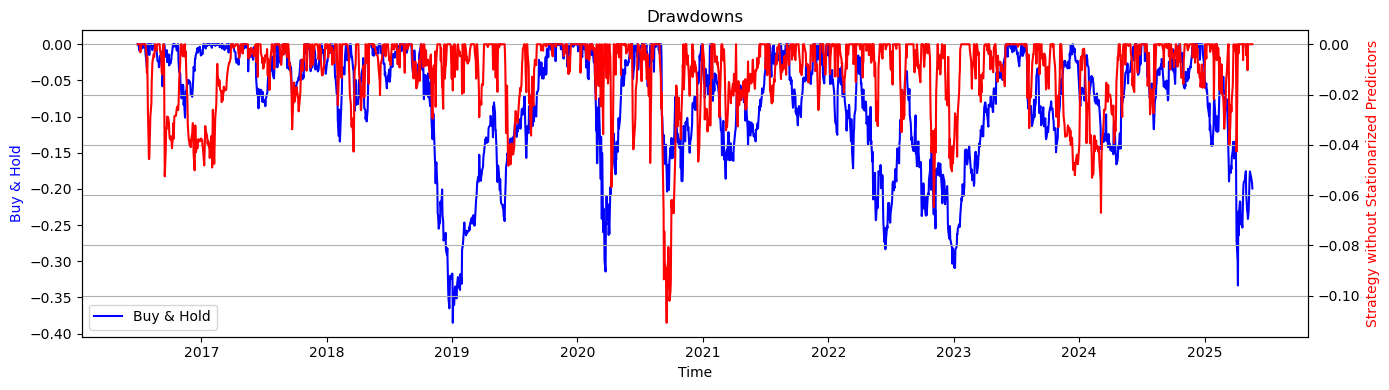

In [28]:
# Plotting drawdowns
fig, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(mdd_bh, color='blue', label='Buy & Hold')
ax2 = ax1.twinx()
ax2.plot(mdd_strategy, color='red', label='Strategy without Stationarized Predictors')
ax1.set_xlabel('Time')
ax1.set_ylabel('Buy & Hold', color='blue')
ax2.set_ylabel('Strategy without Stationarized Predictors', color='red')
plt.title('Drawdowns')
ax1.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Printing results
print(f"Sharpe Ratio (Strategy without Stationarized Predictors):    {sharpe_strategy:.2f}")
print(f"Sharpe Ratio (Buy & Hold):  {sharpe_bh:.2f}")
print(f"Max Drawdown (Strategy without Stationarized Predictors):    {mdd_strategy_val:.2%}")
print(f"Max Drawdown (Buy & Hold):  {mdd_bh_val:.2%}")

Sharpe Ratio (Strategy without Stationarized Predictors):    4.03
Sharpe Ratio (Buy & Hold):  0.83
Max Drawdown (Strategy without Stationarized Predictors):    -11.07%
Max Drawdown (Buy & Hold):  -38.52%


In [30]:
# Calculating hit ratio
positive_trades = len(trades_df[trades_df['Return'] > 0])
negative_trades = len(trades_df[trades_df['Return'] < 0])
hit_ratio = positive_trades * 100 / (positive_trades + negative_trades)
print(f"Hit Ratio of Strategy with Stationarized Predictors: {hit_ratio:.2f}%")

Hit Ratio of Strategy with Stationarized Predictors: 63.52%


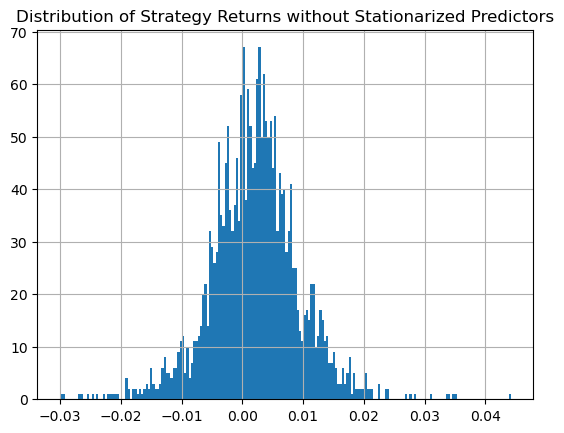

In [31]:
# Plotting strategy returns distribution
returns_series.hist(bins=200)
plt.title("Distribution of Strategy Returns without Stationarized Predictors")
plt.show()

In [32]:
# Calculating average profits and losses
profitable_trades = trades_df[trades_df['Return'] > 0]
loss_making_trades = trades_df[trades_df['Return'] < 0]

avg_profit = profitable_trades['Return'].mean()
avg_loss = loss_making_trades['Return'].mean()

print(f"Average Profit for Profitable Trades without Stationarized Predictors: {avg_profit:.4f}")
print(f"Average Loss Loss-Making Trades without Stationarized Predictors: {avg_loss:.4f}")

Average Profit for Profitable Trades without Stationarized Predictors: 0.0308
Average Loss Loss-Making Trades without Stationarized Predictors: -0.0252


In [33]:
# Calculating CAGR for Buy and Hold
initial_price = final_data['Close'].iloc[0]
final_price = final_data['Close'].iloc[-1]
num_years = len(final_data) / 252  # Assuming 252 trading days in a year

cagr_bh = (final_price / initial_price)**(1 / num_years) - 1

# Calculating CAGR for the strategy
initial_strategy_capital = 10000
final_strategy_capital = strategy_equity.iloc[-1]

cagr_strategy = (final_strategy_capital / initial_strategy_capital)**(1 / num_years) - 1

print(f"CAGR (Buy & Hold): {cagr_bh:.4%}")
print(f"CAGR (Strategy without Stationarized Predictors): {cagr_strategy.iloc[0]:.4%}")

CAGR (Buy & Hold): 29.0152%
CAGR (Strategy without Stationarized Predictors): 66.9908%


In [34]:
# Calculating model performance
# Creating a copy of final_data and selecting relevant columns
final_data_copy = final_data[['Target', 'Predictions']].copy()

# Applying the transformation to the 'Target' column
final_data_copy['Target'] = np.where(final_data_copy['Target'] > 0, 1, -1)

# Applying the transformation to the 'Predictions' column
final_data_copy['Predictions'] = np.where(final_data_copy['Predictions'] > 0, 1, -1)

# Confusion Matrix
cm = confusion_matrix(final_data_copy['Target'], final_data_copy['Predictions'])
print("Confusion Matrix (Non-Stationarized Predictors):\n", cm)

# Accuracy
accuracy = accuracy_score(final_data_copy['Target'], final_data_copy['Predictions'])
print(f"Accuracy (Non-Stationarized Predictors): {accuracy:.4f}")

# Recall
recall = recall_score(final_data_copy['Target'], final_data_copy['Predictions'], pos_label=1)
print(f"Recall (Non-Stationarized Predictors): {recall:.4f}")

# Precision
precision = precision_score(final_data_copy['Target'], final_data_copy['Predictions'], pos_label=1)
print(f"Precision (Non-Stationarized Predictors): {precision:.4f}")

# F1-Score
f1 = f1_score(final_data_copy['Target'], final_data_copy['Predictions'], pos_label=1)
print(f"F1-Score (Non-Stationarized Predictors): {f1:.4f}")

Confusion Matrix (Non-Stationarized Predictors):
 [[545 370]
 [422 899]]
Accuracy (Non-Stationarized Predictors): 0.6458
Recall (Non-Stationarized Predictors): 0.6805
Precision (Non-Stationarized Predictors): 0.7084
F1-Score (Non-Stationarized Predictors): 0.6942


### **Backtesting and Strategy Evaluation on Stationarized Predictors**

In [35]:
# Running walk-forward prediction
model = GradientBoostingRegressor(n_estimators=100)
pred_series_differenced = walk_forward_with_pca_vif(data_merged_differenced, model)
data_merged_differenced['Predictions'] = pred_series_differenced
data_merged_differenced.dropna(subset=['Predictions'], inplace=True)

In [36]:
# Creating final dataset
final_data_differenced = data_merged_differenced[['Open', 'Close', 'Target', 'Predictions']].copy()

# Running backtest
trades_df_differenced = backtest_strategy(final_data_differenced)

In [37]:
# Converting relevant columns to two and four decimal places respectively
cols_to_round_to_two = ['Entry_Price', 'Exit_Price']
trades_df_differenced[cols_to_round_to_two] = trades_df_differenced[cols_to_round_to_two].round(2)
cols_to_round_to_four = ['Return', 'Capital_Change']
trades_df_differenced[cols_to_round_to_four] = trades_df_differenced[cols_to_round_to_four].round(4)

In [38]:
trades_df_differenced

,Signal_Day,Entry_Day,Exit_Day,Direction,Entry_Price,Exit_Price,Return,Capital_Change
0,0,1,5,Long,21.80,22.17,0.0167,0.0033
1,1,2,6,Long,21.62,22.27,0.0298,0.0060
2,2,3,7,Long,21.87,22.14,0.0122,0.0024
3,3,4,8,Short,22.05,22.58,-0.0238,-0.0048
4,4,5,9,Long,22.11,22.58,0.0210,0.0042
...,...,...,...,...,...,...,...,...
2225,2225,2226,2230,Short,198.74,211.45,-0.0640,-0.0128
2226,2226,2227,2231,Short,210.97,211.26,-0.0014,-0.0003
2227,2227,2228,2232,Long,210.43,208.78,-0.0078,-0.0016
2228,2228,2229,2233,Long,212.43,206.86,-0.0262,-0.0052


In [39]:
# Calculating equity
returns_series_differenced = pd.Series(0, index=final_data_differenced.index)
for _, row in trades_df_differenced.iterrows():
    returns_series_differenced.iloc[int(row['Exit_Day'])] += row['Capital_Change']
strategy_equity_differenced = 10000 * (1 + returns_series_differenced).cumprod()
buy_hold_equity_differenced = (final_data_differenced['Close'] / final_data_differenced['Open'].iloc[0]) * 10000

In [40]:
# Calculating trade metrics
rfr_differenced = float(input("Enter the risk-free rate (e.g., for 5.3%, enter only 5.3): "))
sharpe_strategy_differenced = sharpe_ratio(strategy_equity_differenced, rfr_differenced / 100)
sharpe_bh_differenced = sharpe_ratio(buy_hold_equity_differenced, rfr_differenced / 100)
mdd_strategy_val_differenced, mdd_strategy_differenced = max_drawdown(strategy_equity_differenced)
mdd_bh_val_differenced, mdd_bh_differenced = max_drawdown(buy_hold_equity_differenced)

Enter the risk-free rate (e.g., for 5.3%, enter only 5.3):  5.3


In [41]:
# Reindexing the dataframes to datetime index
date_index_differenced = pd.to_datetime(data_merged_differenced['Date'])

mdd_bh_differenced = pd.DataFrame(mdd_bh_differenced).set_index(date_index_differenced)
mdd_strategy_differenced = pd.DataFrame(mdd_strategy_differenced).set_index(date_index_differenced)
strategy_equity_differenced = pd.DataFrame(strategy_equity_differenced).set_index(date_index_differenced)
buy_hold_equity_differenced = pd.DataFrame(buy_hold_equity_differenced).set_index(date_index_differenced)

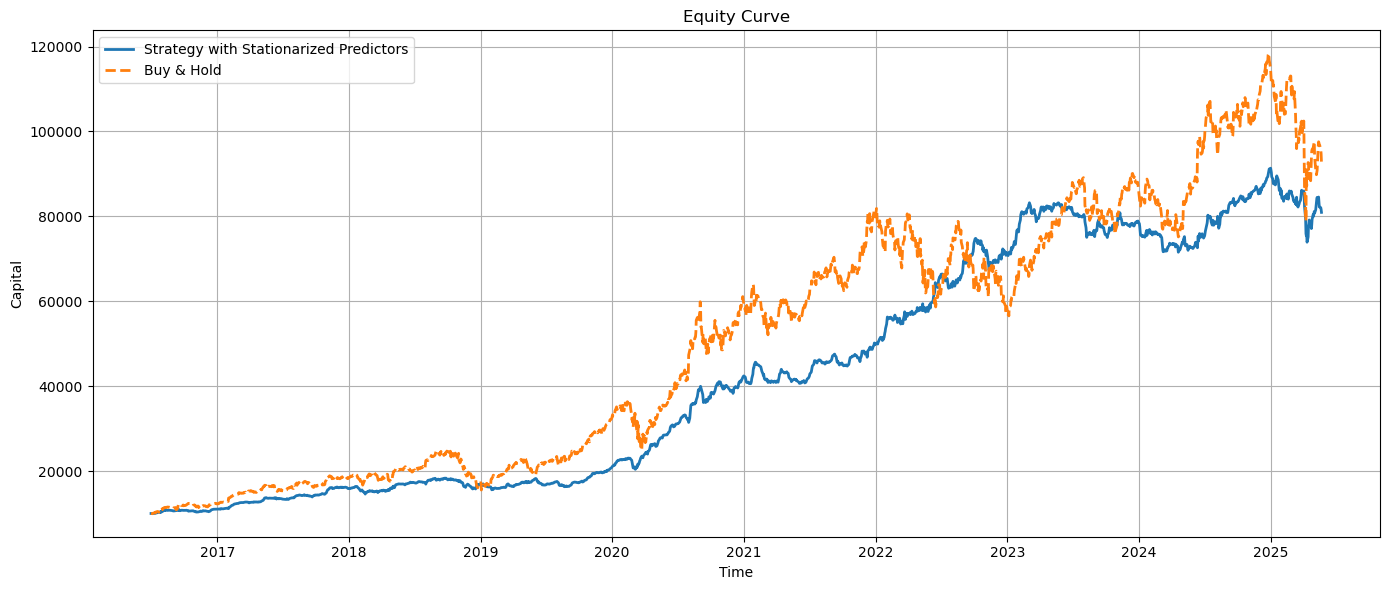

In [42]:
# Plotting equity
plt.figure(figsize=(14, 6))
plt.plot(strategy_equity_differenced, label='Strategy with Stationarized Predictors', linewidth=2)
plt.plot(buy_hold_equity_differenced, label='Buy & Hold', linestyle='--', linewidth=2)
plt.title('Equity Curve')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

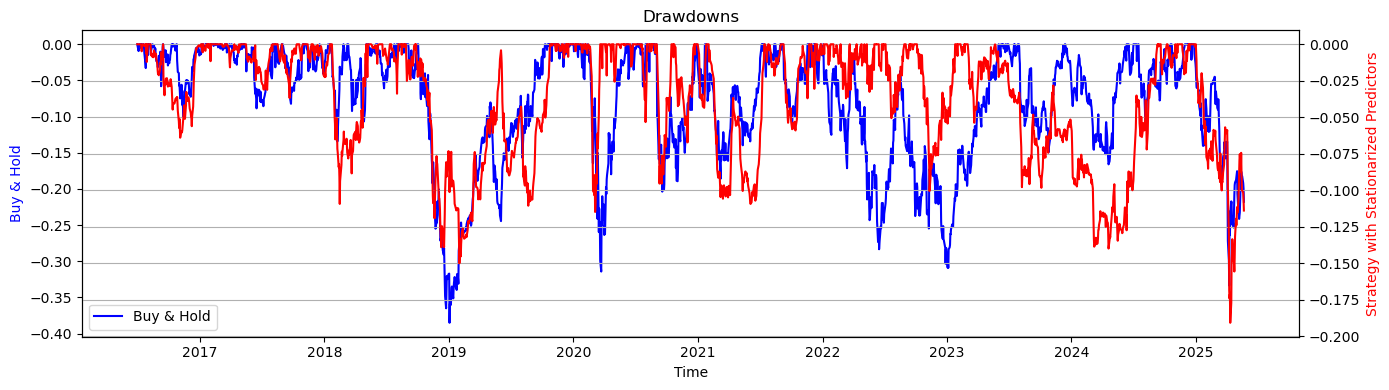

In [43]:
# Plotting drawdowns
fig, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(mdd_bh_differenced, color='blue', label='Buy & Hold')
ax2 = ax1.twinx()
ax2.plot(mdd_strategy_differenced, color='red', label='Strategy with Stationarized Predictors')
ax1.set_xlabel('Time')
ax1.set_ylabel('Buy & Hold', color='blue')
ax2.set_ylabel('Strategy with Stationarized Predictors', color='red')
plt.title('Drawdowns')
ax1.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Printing results
print(f"Sharpe Ratio (Strategy with Stationarized Predictors):    {sharpe_strategy_differenced:.2f}")
print(f"Sharpe Ratio (Buy & Hold):  {sharpe_bh_differenced:.2f}")
print(f"Max Drawdown (Strategy with Stationarized Predictors):    {mdd_strategy_val_differenced:.2%}")
print(f"Max Drawdown (Buy & Hold):  {mdd_bh_val_differenced:.2%}")

Sharpe Ratio (Strategy with Stationarized Predictors):    1.59
Sharpe Ratio (Buy & Hold):  0.82
Max Drawdown (Strategy with Stationarized Predictors):    -19.08%
Max Drawdown (Buy & Hold):  -38.52%


In [45]:
# Calculating hit ratio
positive_trades_differenced = len(trades_df_differenced[trades_df_differenced['Return'] > 0])
negative_trades_differenced = len(trades_df_differenced[trades_df_differenced['Return'] < 0])
hit_ratio_differenced = positive_trades_differenced * 100 / (positive_trades_differenced + negative_trades_differenced)
print(f"Hit Ratio of Strategy with Stationarized Predictors: {hit_ratio_differenced:.2f}%")

Hit Ratio of Strategy with Stationarized Predictors: 56.49%


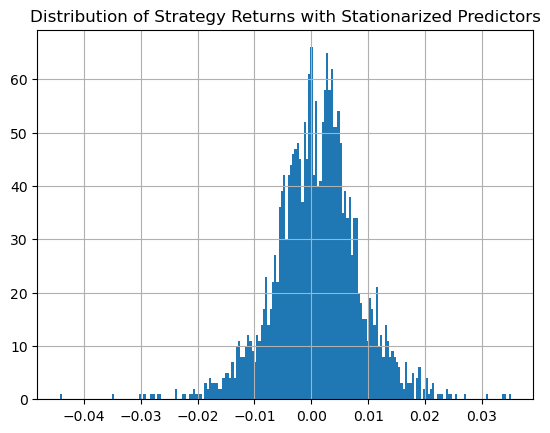

In [46]:
# Plotting strategy returns distribution
returns_series_differenced.hist(bins=200)
plt.title("Distribution of Strategy Returns with Stationarized Predictors")
plt.show()

In [47]:
# Calculating average profits and losses
profitable_trades_differenced = trades_df_differenced[trades_df_differenced['Return'] > 0]
loss_making_trades_differenced = trades_df_differenced[trades_df_differenced['Return'] < 0]

avg_profit_differenced = profitable_trades_differenced['Return'].mean()
avg_loss_differenced = loss_making_trades_differenced['Return'].mean()

print(f"Average Profit for Profitable Trades with Stationarized Predictors: {avg_profit_differenced:.4f}")
print(f"Average Loss Loss-Making Trades with Stationarized Predictors: {avg_loss_differenced:.4f}")

Average Profit for Profitable Trades with Stationarized Predictors: 0.0297
Average Loss Loss-Making Trades with Stationarized Predictors: -0.0275


In [48]:
# Calculating CAGR for Buy and Hold
initial_price_differenced = final_data_differenced['Close'].iloc[0]
final_price_differenced = final_data_differenced['Close'].iloc[-1]
num_years_differenced = len(final_data_differenced) / 252  # Assuming 252 trading days in a year

cagr_bh_differenced = (final_price_differenced / initial_price_differenced)**(1 / num_years_differenced) - 1

# Calculating CAGR for the strategy
initial_strategy_capital_differenced = 10000
final_strategy_capital_differenced = strategy_equity_differenced.iloc[-1]

cagr_strategy_differenced = (final_strategy_capital_differenced / initial_strategy_capital_differenced)**(1 / num_years_differenced) - 1

print(f"CAGR (Buy & Hold): {cagr_bh_differenced:.4%}")
print(f"CAGR (Strategy with Stationarized Predictors): {cagr_strategy_differenced.iloc[0]:.4%}")

CAGR (Buy & Hold): 28.4639%
CAGR (Strategy with Stationarized Predictors): 26.5887%


In [49]:
# Calculating model performance
# Creating a copy of final_data_differenced and selecting relevant columns
final_data_copy_differenced = final_data_differenced[['Target', 'Predictions']].copy()

# Applying the transformation to the 'Target' column
final_data_copy_differenced['Target'] = np.where(final_data_copy_differenced['Target'] > 0, 1, -1)

# Applying the transformation to the 'Predictions' column
final_data_copy_differenced['Predictions'] = np.where(final_data_copy_differenced['Predictions'] > 0, 1, -1)

# Confusion Matrix
cm_differenced = confusion_matrix(final_data_copy_differenced['Target'], final_data_copy_differenced['Predictions'])
print("Confusion Matrix (Stationarized Predictors):\n", cm_differenced)

# Accuracy
accuracy_differenced = accuracy_score(final_data_copy_differenced['Target'], final_data_copy_differenced['Predictions'])
print(f"Accuracy (Stationarized Predictors): {accuracy_differenced:.4f}")

# Recall
recall_differenced = recall_score(final_data_copy_differenced['Target'], final_data_copy_differenced['Predictions'], pos_label=1)
print(f"Recall (Stationarized Predictors): {recall_differenced:.4f}")

# Precision
precision_differenced = precision_score(final_data_copy_differenced['Target'], final_data_copy_differenced['Predictions'], pos_label=1)
print(f"Precision (Stationarized Predictors): {precision_differenced:.4f}")

# F1-Score
f1_differenced = f1_score(final_data_copy_differenced['Target'], final_data_copy_differenced['Predictions'], pos_label=1)
print(f"F1-Score (Stationarized Predictors): {f1_differenced:.4f}")

Confusion Matrix (Stationarized Predictors):
 [[377 539]
 [424 895]]
Accuracy (Stationarized Predictors): 0.5691
Recall (Stationarized Predictors): 0.6785
Precision (Stationarized Predictors): 0.6241
F1-Score (Stationarized Predictors): 0.6502
